In [1]:
import os
import sys
import cv2
import shutil
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import multiprocessing as mp
import matplotlib.pyplot as plt
from tensorflow import set_random_seed
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from keras import backend as K
from keras.models import Model
from keras.utils import to_categorical
from keras import optimizers, applications
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback, LearningRateScheduler

def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    set_random_seed(0)

seed = 0
seed_everything(seed)
%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")
from efficientnet import *


/Users/thanhthao10722/.virtualenvs/dr-1/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/thanhthao10722/.virtualenvs/dr-1/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/thanhthao10722/.virtualenvs/dr-1/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/thanhthao10722/.virtuale

In [2]:
HEIGHT = 224
WIDTH = 224
CHANNELS = 3
weights_path_list = ['../weight/fold_1.h5',
                     '../weight/fold_2.h5', '../weight/fold_3.h5',
                     '../weight/fold_4.h5','../weight/fold_5.h5']

In [3]:
def create_model(input_shape, weights_path):
    input_tensor = Input(shape=input_shape)
    base_model = EfficientNetB5(weights=None, 
                                include_top=False,
                                input_tensor=input_tensor)

    x = GlobalAveragePooling2D()(base_model.output)
    final_output = Dense(1, activation='linear', name='final_output')(x)
    model = Model(input_tensor, final_output)
    model.load_weights(weights_path)
    
    return model

In [4]:
model_list = []

for weights_path in weights_path_list:
    model_list.append(create_model(input_shape=(HEIGHT, WIDTH, CHANNELS), weights_path=weights_path))







Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [22]:
def classify(x):
    if x < 0.5:
        return 0
    elif x < 1.5:
        return 1
    elif x < 2.5:
        return 2
    elif x < 3.5:
        return 3
    return 4

def ensemble_preds(model_list, generator):
    preds_ensemble = []
    for model in model_list:
        generator.reset()
        preds = model.predict_generator(generator, steps=generator.n)
        preds_ensemble.append(preds)

    return np.mean(preds_ensemble, axis=0)

In [23]:
def visualize_stock(img_data):
    plt.figure(1, figsize=(25, 25))
    stock = np.squeeze(img_data, axis=0)
    plt.imshow(stock)

In [24]:
test = pd.read_csv("../data/test.csv")
data_path = "../data/image"
datagen=ImageDataGenerator(rescale=1./255, 
                           rotation_range=360,
                           horizontal_flip=True,
                           vertical_flip=True)
test_generator=datagen.flow_from_dataframe(
                        dataframe=test,
                        directory=data_path,
                        x_col="id_code",
                        y_col="level",
                        class_mode="raw",
                        batch_size=1,
                        shuffle=False,
                        target_size=(HEIGHT, WIDTH),
                        seed=seed)
preds_ensemble = ensemble_preds(model_list, test_generator)
result = [classify(x) for x in preds_ensemble]


Found 5 validated image filenames.
(5, 1) [[2.7557318 ]
 [0.72511685]
 [1.7430716 ]
 [0.2445702 ]
 [0.5941378 ]]
(5, 1) [[3.915596  ]
 [0.19709313]
 [2.6173239 ]
 [1.9305314 ]
 [0.611385  ]]
(5, 1) [[2.265642  ]
 [0.3178764 ]
 [2.1830173 ]
 [0.40173578]
 [0.24974   ]]
(5, 1) [[2.3448977 ]
 [0.23846805]
 [1.8108271 ]
 [1.2263291 ]
 [0.09208721]]
(5, 1) [[4.1030455]
 [0.3024935]
 [1.8726456]
 [1.3412838]
 [1.1020869]]


In [17]:
from keras.preprocessing import image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


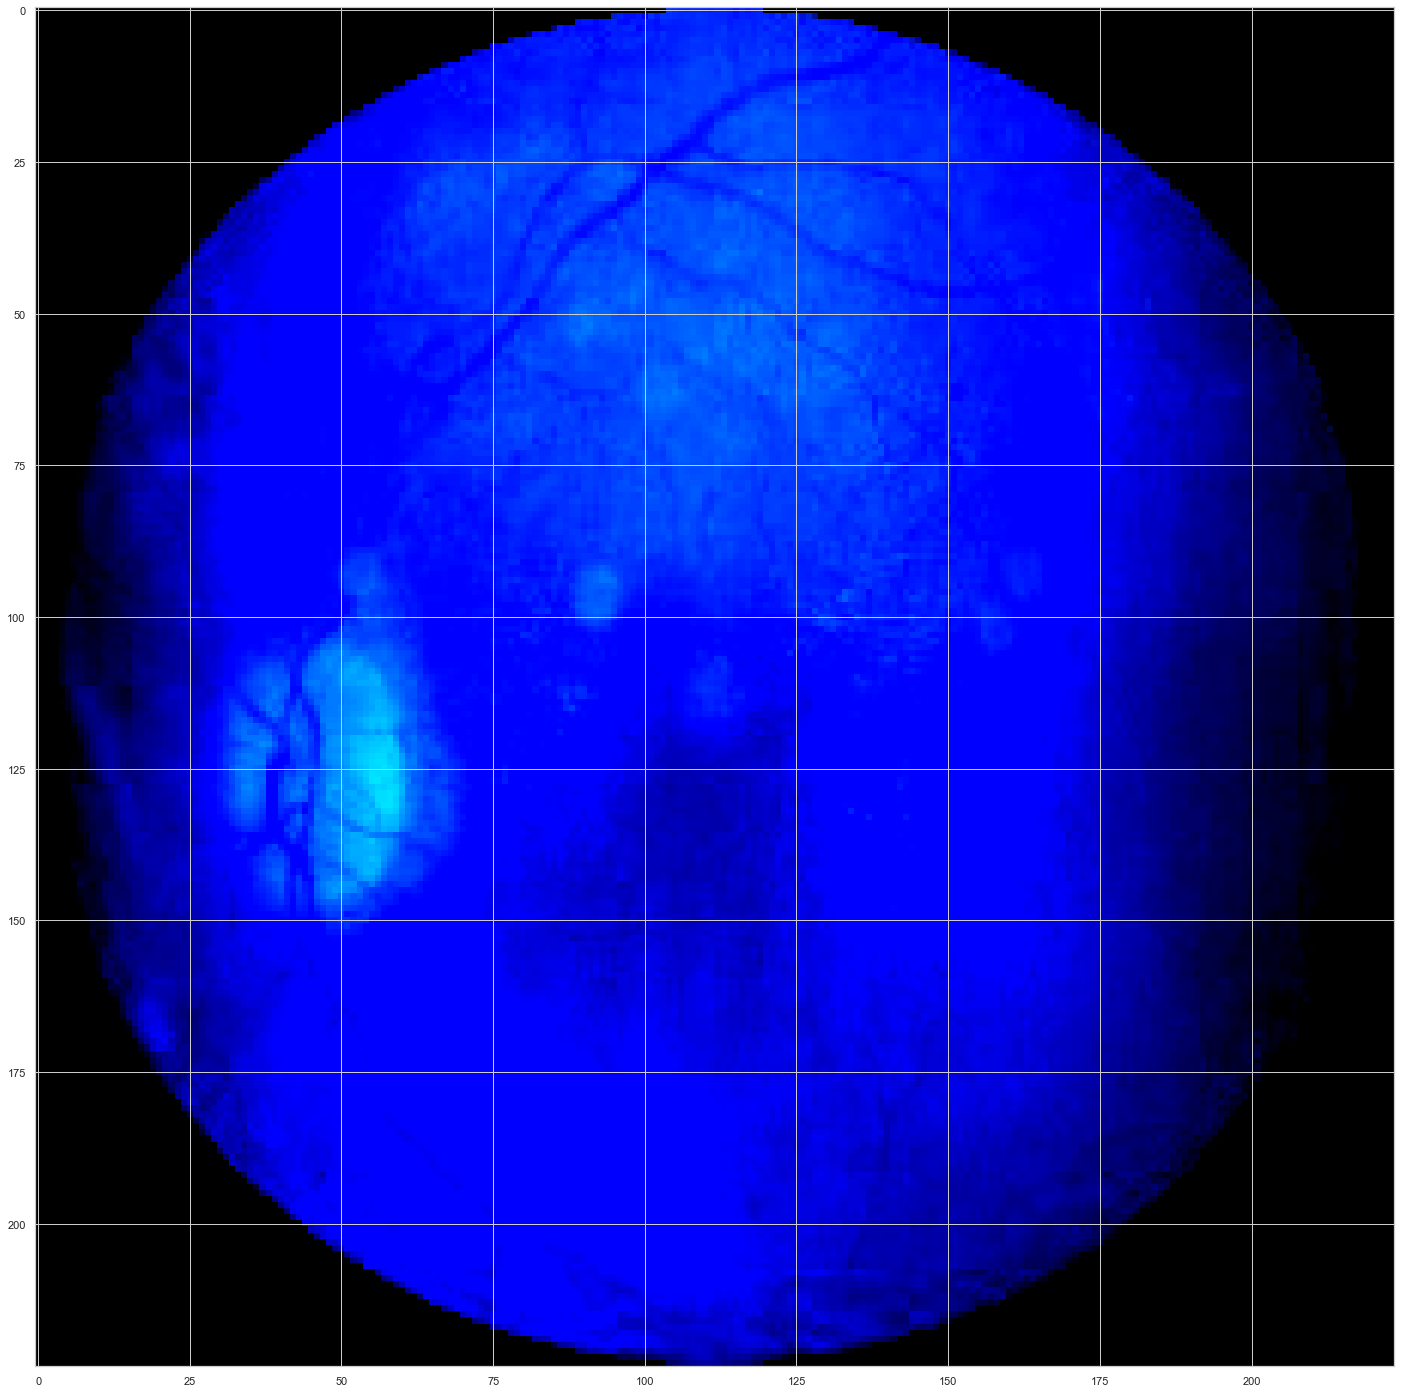

In [32]:
# for img_path in test["id_code"]:
data = test["id_code"][0]
img = image.load_img(f"{data_path}/{data}")
img_data = image.img_to_array(img)
img_data = np.expand_dims(img_data, axis=0)
img_data = preprocess_input(img_data)    
# visualize_stock(img_data)
